In [3]:
import numpy as np
import scipy as sp
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import seaborn as sns
from lib.SinkhornNP import SolveOT
seed = np.random.SeedSequence()
gen = np.random.Generator(np.random.MT19937(seed))

In [4]:
def getDistSqrTorus(x,y):
    dim = 1
    if (x.ndim == 2):
        dim = np.shape(x)[1]
    m = np.shape(x)[0]
    n = np.shape(y)[0]
    return sp.linalg.norm((x.reshape((m,1,dim))-y.reshape((1,n,dim)) + 0.5)%1 - 0.5,axis = 2)**2

def cost(X,Y):
    
    return getDistSqrTorus(X,Y)

def dens_gauss_shift(X, Y, shift, std, shift_prob=0.5):
    """
    X, Y same shape numpy arrays to describe point clouds
    shift = shift of second diagonal
    std = standard deviation of both diagonals
    shift_prob = probability of going to the se
    """
    
    o = np.ceil(4 * std)
    
    a = (Y - X).reshape((*X.shape, 1))
    a = np.nan_to_num(a,nan = std*np.sqrt(2/np.pi) %1)
    z = np.arange(-o, o+1, dtype=float).reshape((*[1 for _ in X.shape], -1))
    
    d0 = 1 / ((2 * np.pi)**.5 * std) * np.sum(np.exp(-(a - z)**2 / (2 * std**2)), axis=-1)
    d1 = 1 / ((2 * np.pi)**.5 * std) * np.sum(np.exp(-(a - shift - z)**2 / (2 * std**2)), axis=-1)
    
    return shift_prob * d1 + (1 - shift_prob) * d0

def sample_Gau(gen,num ,std, shift,dim = 1, shift_prob = 0.5):
    x = gen.random(num)
    shift_ind = gen.choice([0,1], p=[1-shift_prob,shift_prob],size = num)
    gau = gen.normal(0, std, size = num)
    y = x + shift_ind*shift + gau
    y = y%1
    while (dim > 1):
        xx = gen.random(num)
        yy = gen.random(num)
        x = np.vstack((x, xx))
        y = np.vstack((y, yy))
        dim -= 1
    return x.T,y.T

In [25]:
M = 100  #Number of point pair in one Batch
N = 100  #Number of Batches
S = 100  #Number of subsampling, should be smaller than M*N
std = 0.05  #Standard diviation for distance
jump = 0.3  #Distance of shift
jump_prob = 0.5  #Probability of shifting
ve = 50/(M*N)  #Sinkhorn regulariser, suggested order is O(M*N^{-1/dim})
subsample = True
EMML_itr = 10000  #Maxitr for minimisation algo (make it large when M is large)
E = 100  #resolution for output image

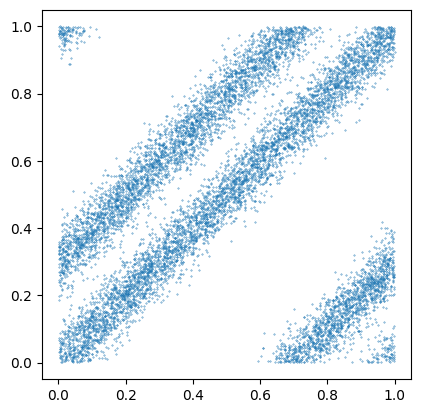

In [26]:
#Test generated samples, 
mn = M*N
x,y = sample_Gau(gen,num = mn ,std = std, shift = jump, shift_prob = jump_prob)
plt.scatter(x,y,s = .1)
_ = plt.axis('scaled')

In [27]:
#Subsample points
S1 = gen.integers(0, mn, size = S)
S2 = gen.integers(0, mn, size = S)
if (subsample):
    sx = x[S1]
    sy = y[S2]
else:
    sx = x
    sy = y
    S = mn
Res_X = SolveOT(np.ones(mn)/mn,np.ones(S)/S,cost(x,sx),1e-9,ve,1,returnSolver = True)
EK_x = Res_X[1].toarray() #Transport plan from mu to subsampled x points
Res_Y = SolveOT(np.ones(mn)/mn,np.ones(S)/S,cost(y,sy),1e-9,ve,1,returnSolver = True)
EK_y = Res_Y[1].toarray() #Transport plan from nu to subsampled y points

In [28]:
#EMML minimisation of cost function

def Pti(x, i):
    return (EK_y.T @ x)[:, np.newaxis] * np.sum(EK_x.T[:,i*M:(i+1)*M], axis=1)[np.newaxis, :] * (S**2 * N)

def Pii(rho, i):
    return (EK_y[i*M:(i+1)*M,:] @ (rho @ np.sum(EK_x.T[:,i*M:(i+1)*M], axis=1))) * (S**2 * N)

def Ptii(x, i):
    return (EK_y[i*M:(i+1)*M,:].T @ x)[:, np.newaxis] * np.sum(EK_x.T[:,i*M:(i+1)*M], axis=1)[np.newaxis, :] * (S**2 * N)



Pcs = [Pti(np.ones(N * M), i) for i in range(N)]
Pcs = np.sum(Pcs,axis=0)
rho = np.full((S, S), S**-2)
pkl = float("inf")
for it in tqdm(range(EMML_itr)):
    kl = 0
    d = np.zeros((S, S))
    for i in range(N):
        d += Ptii(1. / Pii(rho, i), i)
    rho *= d / mn
    rho /= np.sum(rho, axis=1)[:,np.newaxis]* S
    rho /= Pcs 
    pkl = kl

rho*=N
EK_x*=mn*S
EK_y*=mn*S

#Do kernel extension for illustration, x_e and y_e should be close to the true marginal (in this case is uniform so we take linspace) 
x_e = y_e = np.linspace(0,1,E,endpoint = False)
xpot = 1/(np.sum(np.exp((-cost(x_e,sx) + Res_X[2].beta)/ve),axis=1))
ypot = 1/(np.sum(np.exp((-cost(y_e,sy) + Res_Y[2].beta)/ve),axis=1))
F_X = xpot[:,np.newaxis]*np.exp((-cost(x_e,sx) + Res_X[2].beta)/ve)*S
F_Y = ypot[:,np.newaxis]*np.exp((-cost(y_e,sy) + Res_Y[2].beta)/ve)*S
Mat = F_Y@rho@F_X.T

        
    

100%|██████████| 10000/10000 [02:54<00:00, 57.39it/s]


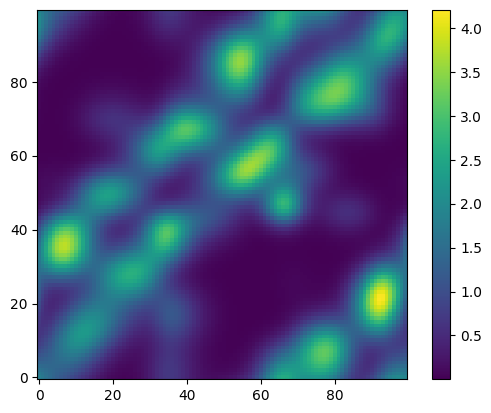

In [29]:
plt.imshow(Mat,origin = "lower")
plt.colorbar()